In [2]:
%config Completer.use_jedi = False

In [3]:
import mipkit
import pydicom
import numpy as np
import torch
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import random
import SimpleITK as sitk
import torchio as tio

from sklearn.model_selection import train_test_split, KFold
from pydicom import dcmread
from datetime import datetime

Data Pre-processing

In [4]:
import glob as glob

In [5]:
all_patient_paths = glob.glob('/media/linh/hdd4TA/ISPY1/manifest-PyHQgfru6393647793776378748/ISPY1/*')
all_patient_paths.sort()

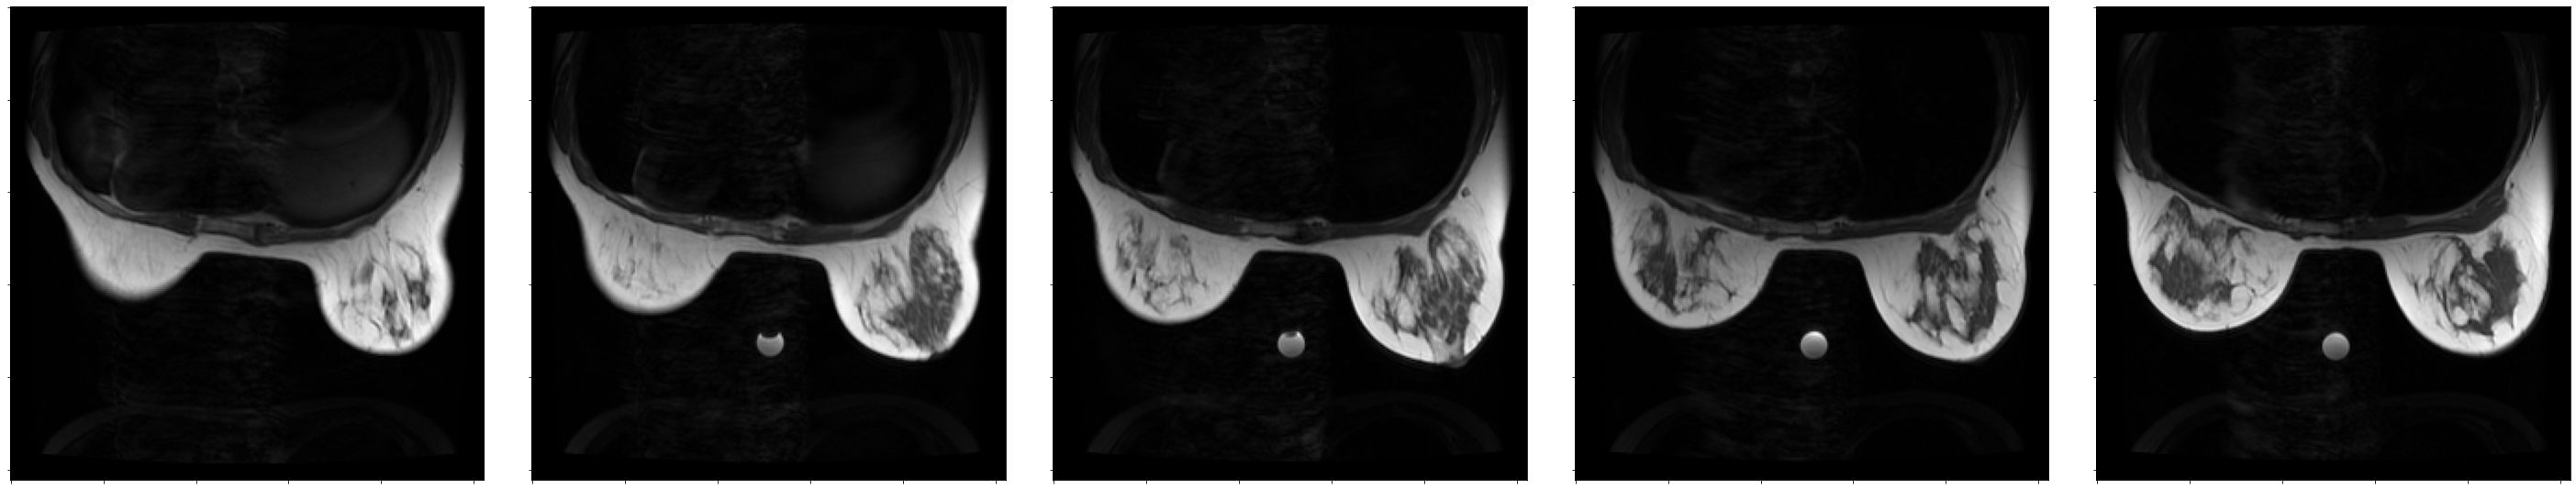

In [49]:
image_test = mipkit.medical.load_DICOM_series('manifest-PyHQgfru6393647793776378748/ISPY1/ISPY1_1002/11-02-1984-868859-MR BREASTUNI UE-60097/1.000000-T1-axial-locator-02405')
mipkit.immulshow(image_test[3:8], cmap='gray')

Because of lack of PCR status label in some patients, I ignore some patients so the number of patients reduce from 222 to 216 patients

In [6]:
for path in all_patient_paths:
    if not os.path.isfile(path):
        patient_id = path.split('/')[-1].split('_')[-1]

        date_folders = glob.glob(path + '/*')
        date_folders.sort(key= lambda x: datetime.strptime(
            x.split('/')[-1][:10], '%m-%d-%Y'), reverse=False)
        target_date_folder = date_folders[0]
        
        image_folder = glob.glob(target_date_folder + '/*')
        image_folder.sort()
        
#         for sub_img in image_folder:
#             for i , slices in enumerate(sorted(os.listdir(sub_img))):
#                 if 'Segmentation' in sub_img:
#                     continue
#                 else:
#                     if i == 0:
#                         print(sub_img.split('/')[-1])
#                         ds = dcmread(sub_img + '/' + slices)
#                         print(ds[('0012', '0050')])      #Clinical Trial Time Point ID 
#                         print(ds[('0018', '0080')])      #Repetition Time
#                         print(ds[('0018', '0081')])      #Echo Time  
#         print('_____________________________________________________________')
        

In [7]:
print('Number of patients in ISPY1 dataset:',len(all_patient_paths))

Number of patients in ISPY1 dataset: 216


In [8]:
# Dataset selection based on:
#     - Choose the first day of each patient
#     - Choose T1 period based on dicom header has tuple value (0012, 0050)
#     - Choose T1 modality based on Echo Time and Repetition Time has tuple values (0018, 0080) and (0018, 0081), respectively
#     - Chooes axial modality based on Image Orientation has tuple value (0020, 0037)

In [9]:
counter = 0
choosen_data = []
T1_orientation = [-1, 0, 0, 0, -1, 0]
T1_repetition = float(500.0)
T1_echo = float(14.0)
for path in all_patient_paths:
                
    if not os.path.isfile(path):
        patient_id = path.split('/')[-1].split('_')[-1]
#         print(patient_id)
        date_folders = glob.glob(path + '/*')
        date_folders.sort(key= lambda x: datetime.strptime(
            x.split('/')[-1][:10], '%m-%d-%Y'), reverse=False)
        target_date_folder = date_folders[0]
        
        image_folders = glob.glob(target_date_folder + '/*')
        image_folders.sort()
        for folder_path in image_folders:
#             if 'T1' in sub_img.split('/')[-1][:15]:
#                 choosen_data.append(sub_img)           
                
            if 'Segmentation' in folder_path:
                    continue
            else:
                all_dicom_filenames = os.listdir(folder_path)
                all_dicom_filenames.sort()
                slices = folder_path + '/' + all_dicom_filenames[0]
#                 print(slices)
                ds = dcmread(slices)

                check_T1 = ds[('0020', '0037')] # 
                check_repetion = ds[('0018', '0080')]
                check_echo = ds[('0018', '0081')]
                
                if np.array_equal(np.array(check_T1.value, np.float), T1_orientation) == True and np.array_equal(np.array(check_repetion.value, np.float), T1_repetition) == True and np.array_equal(np.array(check_echo.value, np.float), T1_echo) == True:
                    choosen_data.append(folder_path)


Unknown encoding 'ISO_IR' - using default encoding instead
Unknown encoding '100' - using default encoding instead


In [10]:
len(choosen_data)

64

In [11]:
# Show all the modalities based on the criteria choosen above
for data in choosen_data:
    for i , slices in enumerate(sorted(os.listdir(data))):
        if i == 0:
            print(data.split('/')[-1])
        
            ds = dcmread(data + '/' + slices)
            print(ds[('0012', '0050')])      #Clinical Trial Time Point ID 
            print(ds[('0018', '0080')])      #Repetition Time
            print(ds[('0018', '0081')])      #Echo Time 
            print(ds[('0020', '0037')])      #Image Orientation
            print(ds[('0020', '0032')])      #Image Position
            
    print('___________________________________________________________')

2.000000-T1-axial-locator-51186
(0012, 0050) Clinical Trial Time Point ID        LO: 'T1'
(0018, 0080) Repetition Time                     DS: '500.0'
(0018, 0081) Echo Time                           DS: '14.0'
(0020, 0037) Image Orientation (Patient)         DS: [-1, 0, 0, 0, -1, 0]
(0020, 0032) Image Position (Patient)            DS: [160, 160, 80]
___________________________________________________________
1.000000-T1-axial-locator-02405
(0012, 0050) Clinical Trial Time Point ID        LO: 'T1'
(0018, 0080) Repetition Time                     DS: '500.0'
(0018, 0081) Echo Time                           DS: '14.0'
(0020, 0037) Image Orientation (Patient)         DS: [-1, 0, 0, 0, -1, 0]
(0020, 0032) Image Position (Patient)            DS: [160, 160, 80]
___________________________________________________________
1.000000-T1-axial-locator-55869
(0012, 0050) Clinical Trial Time Point ID        LO: 'T1'
(0018, 0080) Repetition Time                     DS: '500.0'
(0018, 0081) Echo Time 

In [12]:
# Seed on the random value
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [13]:
# Load pandas file
df = pd.read_csv('PCR_status.csv')
df['SUBJECTID'] = 'ISPY1_' + df['SUBJECTID'].astype(str)
df.head()

,SUBJECTID,DataExtractDt,sstat,survDtD2 (tx),RFS,rfs_ind,PCR,RCBClass
0,ISPY1_1001,9/3/2009,8,1264,751,1,0.0,2.0
1,ISPY1_1002,9/3/2009,8,1155,1043,1,0.0,3.0
2,ISPY1_1003,9/3/2009,7,2387,2387,0,0.0,3.0
3,ISPY1_1004,9/3/2009,7,2436,2436,0,0.0,NaN
4,ISPY1_1005,9/3/2009,7,2220,2520,0,0.0,NaN


In [14]:
test = df.iloc[:,0].tolist()
len(test)

221

In [15]:
# Take Patient Name and PCR status
df_status = pd.concat([df['SUBJECTID'], df['PCR']], axis = 1)
df_status.head()

,SUBJECTID,PCR
0,ISPY1_1001,0.0
1,ISPY1_1002,0.0
2,ISPY1_1003,0.0
3,ISPY1_1004,0.0
4,ISPY1_1005,0.0


In [16]:
# Check nan value 
df['PCR'].isnull().sum()

6

In [17]:
df_status = df_status.dropna(axis = 0)
df_status.head()

,SUBJECTID,PCR
0,ISPY1_1001,0.0
1,ISPY1_1002,0.0
2,ISPY1_1003,0.0
3,ISPY1_1004,0.0
4,ISPY1_1005,0.0


In [18]:
patients = df_status['SUBJECTID'].tolist()
folder_paths_choosen = []

In [19]:
i = 0

for j in range(len(patients)):
    for i in range(len(choosen_data)):
        if patients[j] == choosen_data[i].split('/')[7]:
#             print(patients[j])
#             print(choosen_data[i].split('/')[7])
#             print('__________')
            folder_paths_choosen.append(choosen_data[i].split('/')[7])
    i += 1

print(i)

64


In [20]:
len(folder_paths_choosen)

64

In [21]:
# There are three modalities 
l1=[]
for i in folder_paths_choosen:
    if i not in l1:
        l1.append(i)
    else:
        print(i,end=' ')

ISPY1_1078 ISPY1_1094 ISPY1_1152 

In [22]:
df_final = pd.read_csv('/media/linh/hdd4TA/ISPY1/PCR_status_2.csv')
df_final['Paths'] = pd.Series(choosen_data)

In [23]:
df_final.head()

,SUBJECTID,PCR,Paths
0,1001,0,/media/linh/hdd4TA/ISPY1/manifest-PyHQgfru6393...
1,1002,0,/media/linh/hdd4TA/ISPY1/manifest-PyHQgfru6393...
2,1003,0,/media/linh/hdd4TA/ISPY1/manifest-PyHQgfru6393...
3,1008,0,/media/linh/hdd4TA/ISPY1/manifest-PyHQgfru6393...
4,1009,0,/media/linh/hdd4TA/ISPY1/manifest-PyHQgfru6393...


In [24]:
import itertools

In [25]:
# Dataset and Dataload

from torch.utils.data import Dataset, DataLoader

# Reshape all the modalities into (15, 256, 256) 
def resize_data(data):
    initial_size_x = data.shape[0]
    initial_size_y = data.shape[1]
    initial_size_z = data.shape[2]

    new_size_x = 15
    new_size_y = 256
    new_size_z = 256

    delta_x = initial_size_x / new_size_x
    delta_y = initial_size_y / new_size_y
    delta_z = initial_size_z / new_size_z

    new_data = np.zeros((new_size_x, new_size_y, new_size_z))

    for x, y, z in itertools.product(range(new_size_x),
                                     range(new_size_y),
                                     range(new_size_z)):
        new_data[x][y][z] = data[int(x * delta_x)][int(y * delta_y)][int(z * delta_z)]

    return new_data

class ISPY_1_dataset(Dataset):
    def __init__(self, df_label, transform = None):
        self.df = df_label
        self.dir = df_label['Paths'].tolist()
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):

        reader = sitk.ImageSeriesReader()
        dicom_names = reader.GetGDCMSeriesFileNames(self.dir[idx])
               
        reader.SetFileNames(dicom_names)
        image = reader.Execute()
        img = sitk.GetArrayViewFromImage(image)
        
        
        pcr_list = self.df['PCR'].tolist()
        pCR_status = pcr_list[idx]
        
        img_resize = resize_data(img)
        
        # Pre-processing data
        img_new = np.zeros(img_resize.shape)
        
        brain_region = img_resize > 0
        
        mean = np.mean(img_resize[brain_region])
        stdev = np.std(img_resize[brain_region])
        
        img_new[brain_region] = (img_resize[brain_region] - mean) / stdev

        # Normalization
        Maximun = np.max(img_new[brain_region])
        Minimun = np.min(img_new[brain_region])

        img_new[brain_region] = (img_new[brain_region] - Minimun) / (Maximun - Minimun)
        
        
        img_tensor = torch.from_numpy(img_new)
        img_tensor = img_tensor.unsqueeze(dim=0)
        
        if self.transform:
            img_tensor = self.transform(img_tensor)
        
        return img_tensor, pCR_status

In [26]:
# Split train, valid and test set
df_training, df_test = train_test_split(df_final, train_size= 0.8)
df_train, df_valid = train_test_split(df_training, train_size = 0.8)

transform = tio.Compose([
            tio.RandomAffine(),
            tio.RandomGamma(p=0.5),
            tio.RandomNoise(p=0.5),
            tio.RandomMotion(p=0.1),
            tio.RandomBiasField(p=0.25)
        ])

train_dataset = ISPY_1_dataset(df_label=df_train, transform = transform)
train_loader = DataLoader(train_dataset, batch_size=1) 

valid_dataset = ISPY_1_dataset(df_label=df_valid)
valid_loader = DataLoader(valid_dataset, batch_size=1)

test_dataset = ISPY_1_dataset(df_label=df_test)
test_loader = DataLoader(test_dataset, batch_size=1)

print('Number of training data: ', len(train_dataset))
print('Number of valid data: ', len(valid_dataset))
print('Number of test data: ', len(test_dataset))

Number of training data:  40
Number of valid data:  11
Number of test data:  13


Model

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from functools import partial
import torch.utils.model_zoo as model_zoo

# 3D Resnet

__all__ = ['ResNet3d', 'get_resnet3d']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
}

def conv3x3x3(in_planes, out_planes, stride=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)


def downsample_basic_block(x, planes, stride):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(
        out.size(0), planes - out.size(1), out.size(2), out.size(3),
        out.size(4)).zero_()
    if isinstance(out.data, torch.cuda.FloatTensor):
        zero_pads = zero_pads.cuda()

    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet3d(nn.Module):
    def __init__(self, block, layers, n_classes=1, shortcut_type='B'):
        self.inplanes = 64
        super(ResNet3d, self).__init__()
        
        self.conv1 = nn.Conv3d(3, 64, kernel_size=7, stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0], shortcut_type)
        
        self.layer2 = self._make_layer(
            block, 128, layers[1], shortcut_type, stride=2)
        
        self.layer3 = self._make_layer(
            block, 256, layers[2], shortcut_type, stride=2)
        
        self.layer4 = self._make_layer(
            block, 512, layers[3], shortcut_type, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        
        self.drop = nn.Dropout3d(0.5)
        
        self.fc = nn.Linear(512 * block.expansion, 512)
        
        self.fc_classification = nn.Linear(512, 2)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def transfer_weights(self, state_dict):
        
        """
        Transfers weights of a pretrained ResNet model on the ImageNet dataset.
        5D weight kernels are initialized from 4D kernels using the '' method.
        :param state_dict: the state dictionary of the loaded BaseNet model.
        :return: None
        """

        def _to_5d_tensor(k):
            """Converts a 4d kernel weights tensor to 5d using the '' method"""
            k = k.unsqueeze(2)
            k.repeat(1, 1, k.size()[-1], 1, 1)
            k = k / k.size()[-1]
            return k

        for key in state_dict.keys():
            x = state_dict[key]
            x = _to_5d_tensor(x) if len(x.size()) == 4 else x

            if key.startswith('conv1') | key.startswith('bn1'):
                eval('self.' + key + '.data.copy_(x)')
            elif key.startswith('layer'):
                var = key.split('.')
                if var[2] == 'downsample':
                    eval('self.' + var[0] + '[' + var[1] + '].downsample[' + var[3] + '].' +
                         var[4] + '.data.copy_(x)')
                else:
                    eval('self.' + var[0] + '[' + var[1] + '].' + var[2] + '.' + var[3] + '.data.copy_(x)')

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.drop(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        group_classification = self.fc_classification(x)

        return group_classification


def get_resnet3d(backbone='resnet18', n_classes=2, pretrained=False, **kwargs):
    
    """
    Constructs a 3D-ResNet model by inflating 2D convolutions into 3D.
    :param backbone: the ResNet backbone, either `resnet18` or `resnet34`.
    :param n_classes: the number of classes in the dataset.
    :param pretrained: If True, returns a model pre-trained on ImageNet.
    """

    # copying modules from pretrained models
    if backbone == 'resnet18':
        model = ResNet3d(BasicBlock, [2, 2, 2, 2], n_classes, **kwargs)
        if pretrained:
            model.transfer_weights(model_zoo.load_url(model_urls['resnet18']))
    elif backbone == 'resnet34':
        model = ResNet3d(BasicBlock, [3, 4, 6, 3], n_classes, **kwargs)
        if pretrained:
            model.transfer_weights(model_zoo.load_url(model_urls['resnet34']))
    else:
        raise ValueError('Unsupported backbone: {}'.format(backbone))

    return model

In [28]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = get_resnet3d(backbone='resnet34', pretrained=True)
model.conv1 = nn.Conv3d(in_channels=1, out_channels=64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
model = model.to(device)

summary(model, input_size=(1, 15, 256, 256))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 15, 128, 128]          21,952
       BatchNorm3d-2     [-1, 64, 15, 128, 128]             128
              ReLU-3     [-1, 64, 15, 128, 128]               0
         MaxPool3d-4        [-1, 64, 8, 64, 64]               0
            Conv3d-5        [-1, 64, 8, 64, 64]         110,592
       BatchNorm3d-6        [-1, 64, 8, 64, 64]             128
              ReLU-7        [-1, 64, 8, 64, 64]               0
            Conv3d-8        [-1, 64, 8, 64, 64]         110,592
       BatchNorm3d-9        [-1, 64, 8, 64, 64]             128
             ReLU-10        [-1, 64, 8, 64, 64]               0
       BasicBlock-11        [-1, 64, 8, 64, 64]               0
           Conv3d-12        [-1, 64, 8, 64, 64]         110,592
      BatchNorm3d-13        [-1, 64, 8, 64, 64]             128
             ReLU-14        [-1,

In [29]:
model

ResNet3d(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

Training and Validation

In [30]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler

In [31]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [32]:
model = model.to(device)
criterion = criterion.to(device)

In [33]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [34]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device).float()
        y = y.to(device).long()
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [35]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device).float()
            y = y.to(device).long()

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [37]:
import time

In [38]:
EPOCHS = 100

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 11s
	Train Loss: 1.549 | Train Acc: 45.00%
	 Val. Loss: 0.478 |  Val. Acc: 81.82%
Epoch: 02 | Epoch Time: 1m 8s
	Train Loss: 0.950 | Train Acc: 52.50%
	 Val. Loss: 1.146 |  Val. Acc: 81.82%
Epoch: 03 | Epoch Time: 1m 9s
	Train Loss: 0.785 | Train Acc: 47.50%
	 Val. Loss: 1.048 |  Val. Acc: 81.82%
Epoch: 04 | Epoch Time: 1m 7s
	Train Loss: 0.728 | Train Acc: 57.50%
	 Val. Loss: 10.056 |  Val. Acc: 81.82%
Epoch: 05 | Epoch Time: 1m 7s
	Train Loss: 0.767 | Train Acc: 50.00%
	 Val. Loss: 0.554 |  Val. Acc: 81.82%
Epoch: 06 | Epoch Time: 1m 9s
	Train Loss: 0.781 | Train Acc: 45.00%
	 Val. Loss: 0.518 |  Val. Acc: 81.82%
Epoch: 07 | Epoch Time: 1m 13s
	Train Loss: 0.729 | Train Acc: 57.50%
	 Val. Loss: 0.588 |  Val. Acc: 81.82%
Epoch: 08 | Epoch Time: 1m 16s
	Train Loss: 0.764 | Train Acc: 37.50%
	 Val. Loss: 0.652 |  Val. Acc: 81.82%
Epoch: 09 | Epoch Time: 1m 15s
	Train Loss: 0.738 | Train Acc: 45.00%
	 Val. Loss: 0.690 |  Val. Acc: 81.82%
Epoch: 10 | Epoch Time:

In [39]:
# Model Evaluation

model.load_state_dict(torch.load('best-model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.218 | Test Acc: 69.23%


In [47]:
# Model Evaluation

model.load_state_dict(torch.load('best-model.pt'))

valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)

print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

Valid Loss: 0.293 | Valid Acc: 81.82%
